In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

from shutil import copy
from shutil import copytree, rmtree

In [ ]:
#Download Food-101 dataset
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz


In [ ]:
#Uncompress the tar file

!tar xzvf food-101.tar.gz
!ls food-101/images

In [ ]:
root_dir = 'food-101/images/'


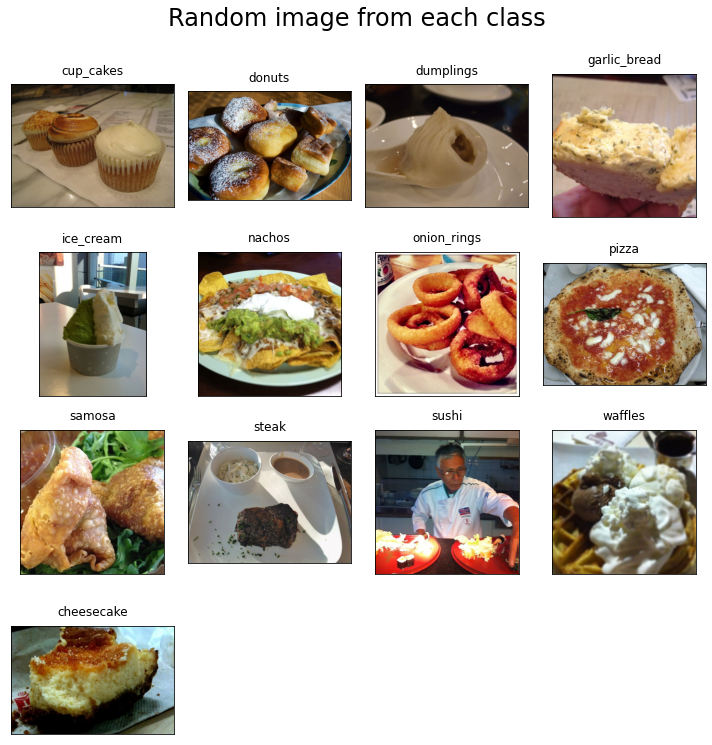

In [ ]:
#Plots a random image from each of the 13 food classes

rows = 4
columns = 4
fig, ax = plt.subplots(rows, columns, figsize=(10,10))
fig.delaxes(ax[3][1])
fig.delaxes(ax[3][2])
fig.delaxes(ax[3][3])

fig.suptitle("Random image from each class", y=1.05, fontsize=24) 
data_dir = "food-101/images/"
foods_sorted =['cup_cakes','donuts','dumplings','garlic_bread','ice_cream','nachos','onion_rings','pizza','samosa','steak','sushi','waffles','cheesecake']
food_id = 0

for i in range(rows):
  
  for j in range(columns):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [ ]:
#Function to split images into train and test folders

def train_test_split(source, destination, file_path):

  classes = defaultdict(list)

  with open(file_path, 'r') as f:
      image_paths = [line.strip() for line in f.readlines()]

      for path in image_paths:

        food_name = path.split('/')
        classes[food_name[0]].append(food_name[1] + '.jpg')

  for food in classes.keys():
    print("\nCopying images into folder:",food)
    if not os.path.exists(os.path.join(destination,food)):
      os.makedirs(os.path.join(destination,food))
    
    for i in classes[food]:
      copy(os.path.join(source,food,i), os.path.join(destination,food,i))
  print("Copying Completed")





In [ ]:
# call train_test_split function to segregate train and test images
print("Creating train folder")
train_test_split( 'food-101/images', 'food-101/train','food-101/meta/train.txt')

print("Creating test folder")
train_test_split('food-101/images', 'food-101/test','food-101/meta/test.txt')





In [ ]:
print("Total number of images in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

print("Total number of images in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

# training_set_np.tofile('image_data.dat')

Total number of images in train folder
75750
Total number of images in test folder
25250


In [ ]:
#creating a list of 13 food classes on which we will perform classification

food_list=['cup_cakes','donuts','dumplings','garlic_bread','ice_cream','nachos','onion_rings','pizza','samosa','steak','sushi','waffles','cheesecake']
src_train = 'food-101/train'
dest_train = 'food-101/train_classification'
src_test = 'food-101/test'
dest_test = 'food-101/test_classification'

In [ ]:
# Function to copy the images of just the 13 food classes to a new train/test folder
def dataset_classification(food_list, source, destination):
  if os.path.exists(destination):
    rmtree(destination)
  os.makedirs(destination)

  for food in food_list :
    print("Copying images into folder",food)
    copytree(os.path.join(source,food), os.path.join(destination,food))

In [ ]:
# Call dataset_classification to move relevant class of images to new train/test folders

print("Copying images into train_classification directory:")
dataset_classification(food_list, src_train, dest_train)
print("Copying images into test_classification directory:")
dataset_classification(food_list, src_test, dest_test)

In [ ]:
!find food-101/train_classification/ -type d -or -type f -printf '.' | wc -c
!find food-101/test_classification/ -type d -or -type f -printf '.' | wc -c

9750
3250


**VGG-16**

In [ ]:
#Implementation of VGG-16 model

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

K.clear_session()

n_classes = 13
img_width, img_height = 299, 299
train_dir = 'food-101/train_classification'
validation_dir = 'food-101/test_classification'
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


vgg16 = VGG16(weights='imagenet', include_top=False)
#uncomment the below couple of lines to freeze all layers of the network
# for layer in vgg16.layers:
#   layer.trainable = False
x = vgg16.output
x = GlobalAveragePooling2D()(x)


output = Dense(13,kernel_regularizer=regularizers.l2(0.002), activation='softmax')(x)

model = Model(inputs=vgg16.input, outputs=output)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator,validation_data=validation_generator,epochs=12,verbose=1)
model.save('model_trained_11class.hdf5')





Found 9750 images belonging to 13 classes.
Found 3250 images belonging to 13 classes.
58892288/58889256 [==============================] - 0s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/12
610/610 [==============================] - 318s 521ms/step - loss: 2.1707 - accuracy: 0.2968 - val_loss: 1.5738 - val_accuracy: 0.5105
Epoch 2/12
610/610 [==============================] - 316s 518ms/step - loss: 1.4946 - accuracy: 0.5474 - val_loss: 1.1113 - val_accuracy: 0.6794
Epoch 3/12
610/610 [==============================] - 312s 512ms/step - loss: 1.1847 - accuracy: 0.6541 - val_loss: 0.8193 - val_accuracy: 0.7794
Epoch 4/12
610/610 [==============================] - 315s 516ms/step - loss: 1.0006 - accuracy: 0.7059 - val_loss: 0.7624 - val_accuracy: 0.7920
Epoch 5/12
610/610 [==============================] - 313s 513ms/step - loss: 0.8681 - accuracy: 0.7456 - val_loss: 0.7301 - val_accuracy: 0.7997
Epoch 6/12
610/610 [=======================

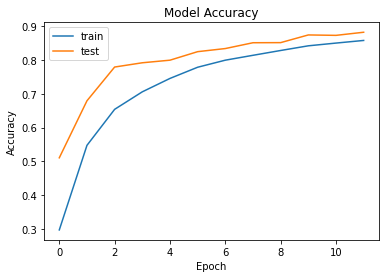

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



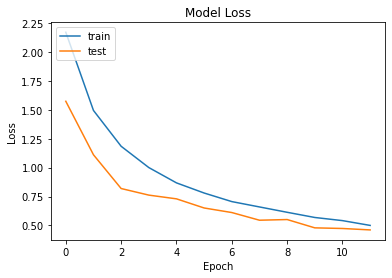

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

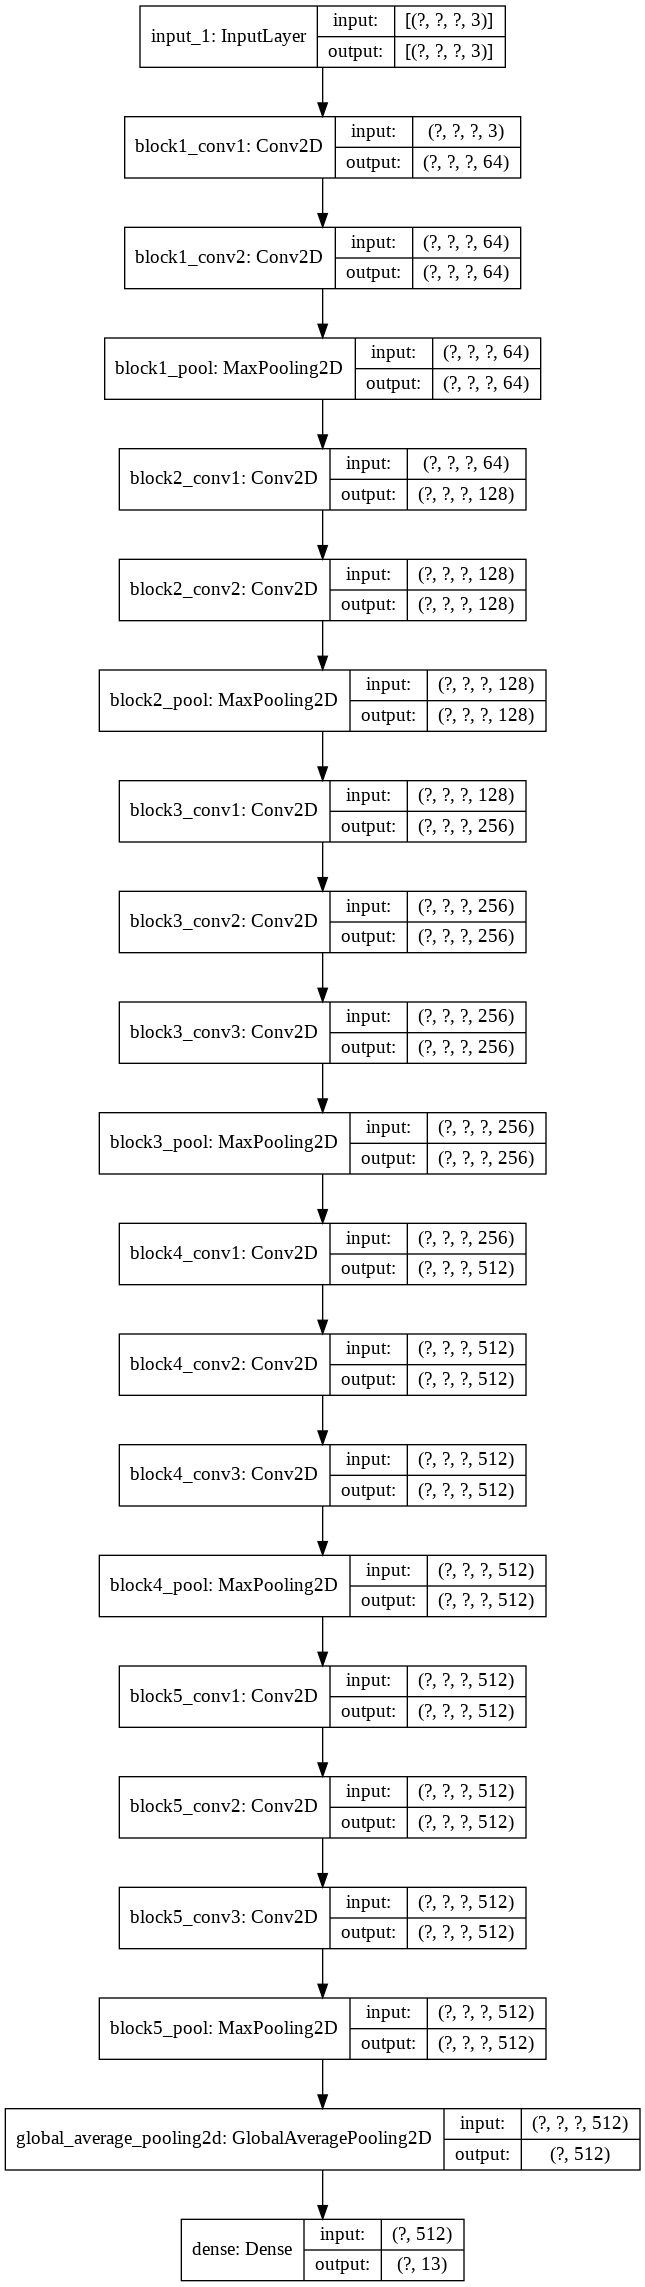

In [ ]:
#plot network architecture
import tensorflow as tf
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**VGG-19**

In [ ]:
#Implementation of VGG-19 model
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

K.clear_session()

n_classes = 13
img_width, img_height = 299, 299
train_dir = 'food-101/train_classification'
validation_dir = 'food-101/test_classification'
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


vgg19 = VGG19(weights='imagenet', include_top=False)
#Uncomment the below couple of lines to freeze all layers of the network
# for layer in inception.layers:
#   layer.trainable = False
x = vgg19.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128,activation='relu')(x)
# x = Dropout(0.2)(x)

output = Dense(13,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=vgg19.input, outputs=output)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit_generator(train_generator,validation_data=validation_generator,epochs=12,verbose=1)
model.save('model_trained_11class.hdf5')





Found 9750 images belonging to 13 classes.
Found 3250 images belonging to 13 classes.
80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/12
610/610 [==============================] - 345s 566ms/step - loss: 2.2109 - accuracy: 0.3123 - val_loss: 1.4404 - val_accuracy: 0.5717
Epoch 2/12
610/610 [==============================] - 348s 571ms/step - loss: 1.4041 - accuracy: 0.5995 - val_loss: 1.0050 - val_accuracy: 0.7320
Epoch 3/12
610/610 [==============================] - 345s 565ms/step - loss: 1.0963 - accuracy: 0.7007 - val_loss: 0.8950 - val_accuracy: 0.7640
Epoch 4/12
610/610 [==============================] - 340s 558ms/step - loss: 0.9291 - accuracy: 0.7498 - val_loss: 0.9824 - val_accuracy: 0.7468
Epoch 5/12
610/610 [==============================] - 340s 557ms/step - loss: 0.8325 - accuracy: 0.7797 - val_loss: 0.6666 - val_accuracy: 0.8317
Epoch 6/12
610/610 [==============================] - 339s 556ms/step - loss: 0.7463 - accuracy: 0.8022 - val_loss: 0.6

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

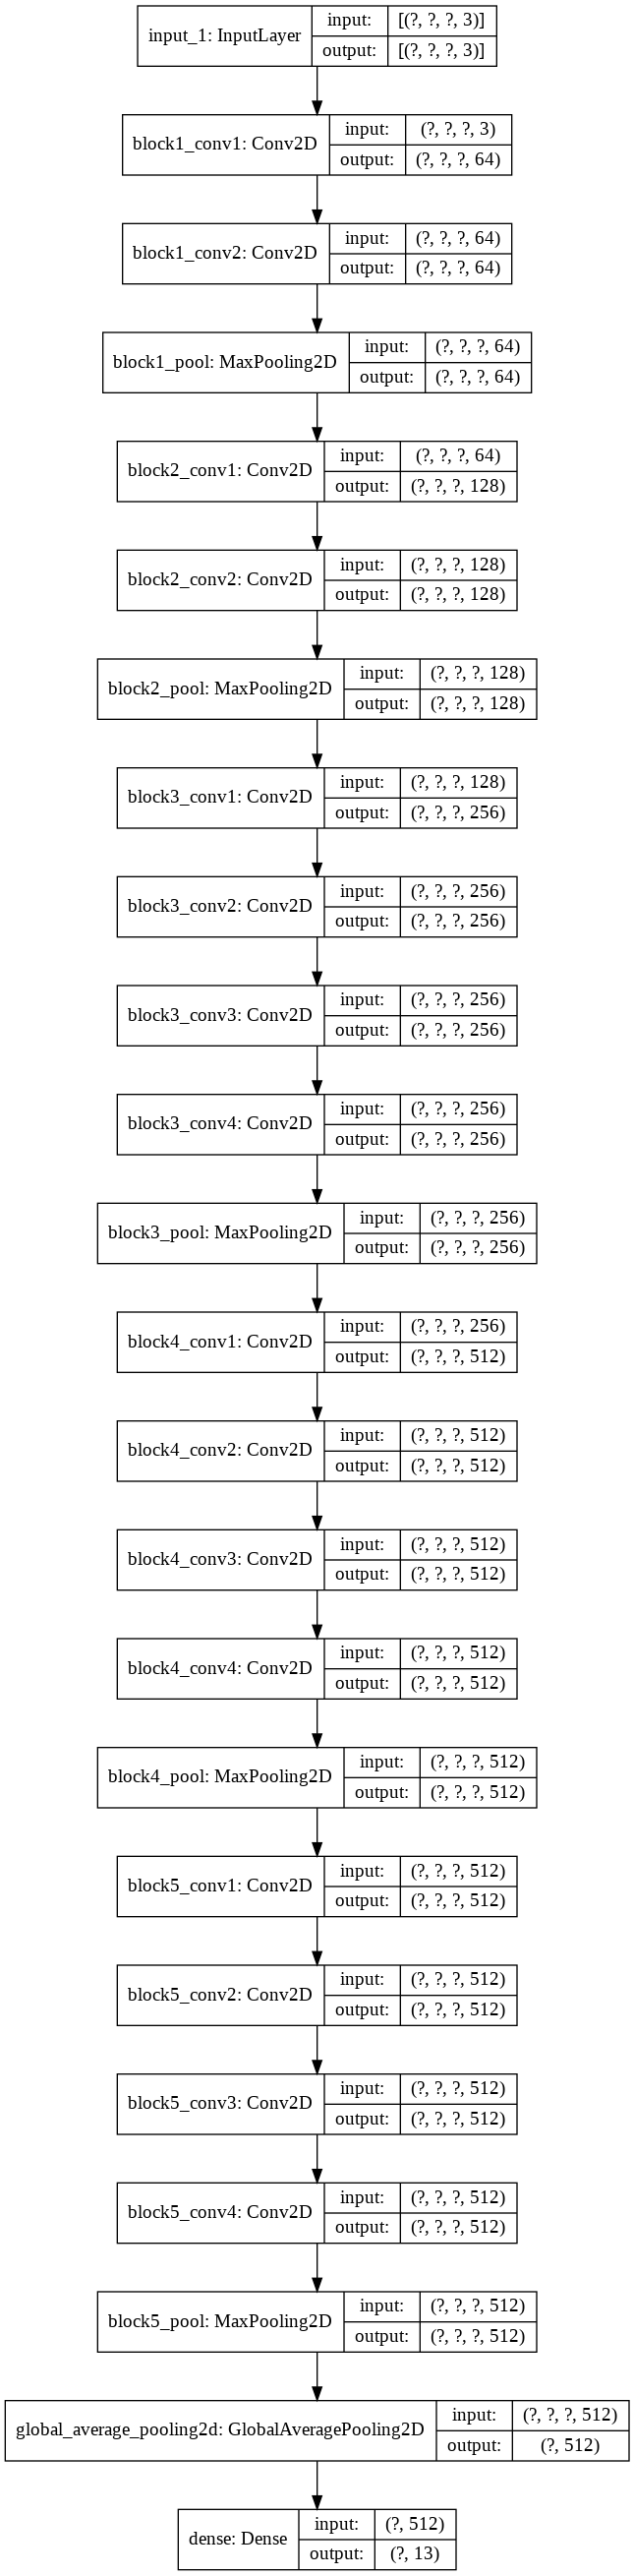

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

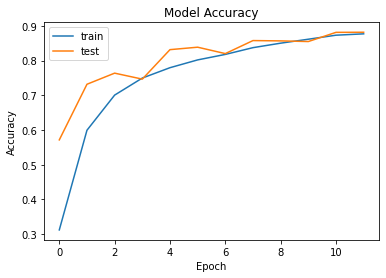

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

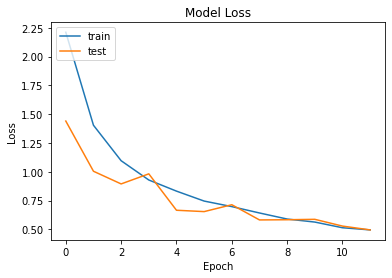

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**InceptionV3**

In [ ]:
#Implementation of InceptionV3 model
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

K.clear_session()

n_classes = 13
img_width, img_height = 299, 299
train_dir = 'food-101/train_classification'
validation_dir = 'food-101/test_classification'
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
#uncomment the below couple of lines to freeze all layers of the network
# for layer in inception.layers:
#   layer.trainable = False
x = inception.output
x = GlobalAveragePooling2D()(x)


output = Dense(13,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=output)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator,validation_data=validation_generator,epochs=12,verbose=1)
model.save('model_Inception.hdf5')





Found 9750 images belonging to 13 classes.
Found 3250 images belonging to 13 classes.
87916544/87910968 [==============================] - 1s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/12
610/610 [==============================] - 387s 635ms/step - loss: 2.1742 - accuracy: 0.4256 - val_loss: 1.3883 - val_accuracy: 0.7622
Epoch 2/12
610/610 [==============================] - 378s 620ms/step - loss: 1.3173 - accuracy: 0.7088 - val_loss: 0.8217 - val_accuracy: 0.8483
Epoch 3/12
610/610 [==============================] - 377s 617ms/step - loss: 0.9866 - accuracy: 0.7721 - val_loss: 0.6335 - val_accuracy: 0.8815
Epoch 4/12
610/610 [==============================] - 373s 611ms/step - loss: 0.8460 - accuracy: 0.7961 - val_loss: 0.5462 - val_accuracy: 0.8948
Epoch 5/12
610/610 [==============================] - 388s 637ms/step - loss: 0.7393 - accuracy: 0.8273 - val_loss: 0.4937 - val_accuracy: 0.9031
Epoch 6/12
610/610 [=======================

In [ ]:
# Plot the network architecture
import tensorflow as tf
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

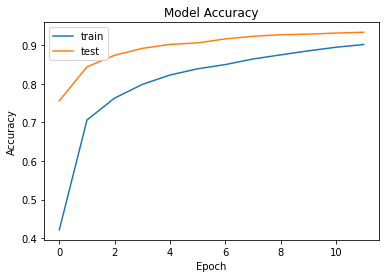

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


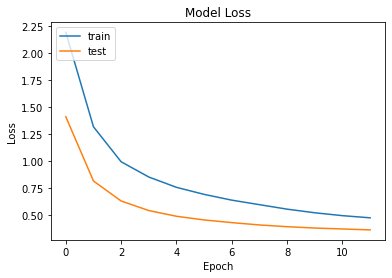

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()